In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr

# Ilan
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from icecream import ic
import nc_time_axis
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [3]:
def preprocess(ds):
    res = ds \
        .assign(wind=lambda x: np.sqrt(x['ua']**2 + x['va']**2)) \
        .assign(height=lambda x: x['zg'] / 9.807) # geopotential
    #.assign(swind=lambda x: np.sqrt(x['uas']**2 + x['vas']**2)) \
    return res

In [49]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7 # Wind speeds are messed up for zoom 7 and less
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask().drop_vars('cell')
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords).pipe(preprocess)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)
ds

/home/iv4111/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 101.23 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 101.08 ms


/home/iv4111/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1TB
Dimensions:  (time: 3560, cell: 196608, plev: 31, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables: (12/40)
    clivi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clt      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clwvi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hflsd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hfssd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hur      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    ...       ...
    vas      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    wa       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    wap      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    zg       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    wind     (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    height   (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>

In [5]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    
def usmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=-90)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent([-130, -70, 20, 50])
    
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
    
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    #ax.coastlines(linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

[########################################] | 100% Completed | 10.22 s
[########################################] | 100% Completed | 10.26 s


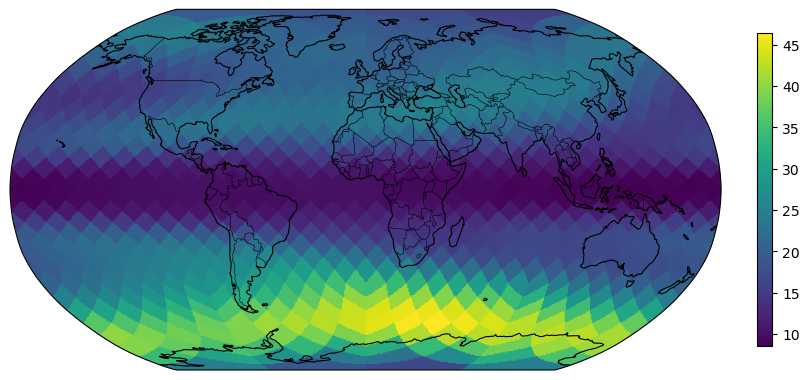

In [17]:
worldmap(ds.wind.sel(time=slice('2020-01-01', '2020-12-31')).mean(dim=['time', 'plev']))

[########################################] | 100% Completed | 9.62 ss


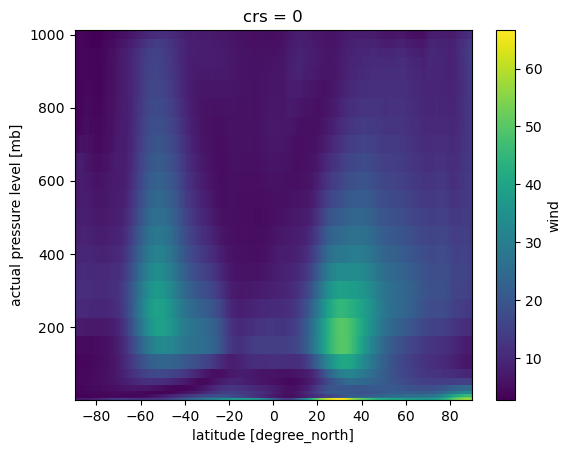

In [50]:
ds.wind.sel(time=slice('2020-01-01', '2020-02-01')).mean('time').groupby('lat').mean(skipna=True).plot()

[########################################] | 100% Completed | 204.06 ms


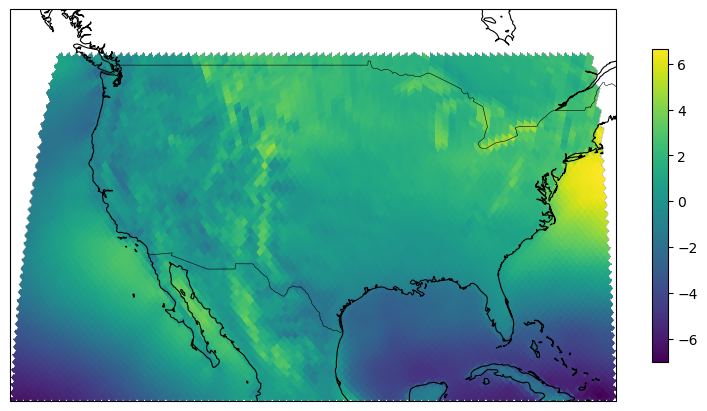

In [51]:
# Select the GPPLJ regions
us = ((ds.lat <= 50) & (ds.lat >= 20) & (ds.lon >= -130+360) & (ds.lon <= -70+360))
ds_us = ds.isel(cell=us)
usmap(ds_us.uas.sel(time=slice('2020-01-01', '2020-02-01')).mean('time'))

## Detection algorithm

Based on 
 >Luiz, E. W., & Fiedler, S. (2024). Global climatology of low‐level‐jets: Occurrence, characteristics, and meteorological drivers. Journal of Geophysical Research: Atmospheres, 129(9), e2023JD040262.

which adapted an algorithm created by 
> Fiedler, S., Schepanski, K., Heinold, B., Knippertz, P., & Tegen, I. (2013). Climatology of nocturnal low‐level jets over North Africa and implications for modeling mineral dust emission. Journal of Geophysical Research: Atmospheres, 118(12), 6100-6121.

### Algorithm
1. Core must be in the lowest 1,000 m
2. Vertical shear more negative than 0.005 s$^{-1}$ in the 500 m deep layer above the LLJ core
3. Difference between same layers of 2 m s$^{-1}$ (do this step first to make math easier)

Nuanced difference -> the shear is done using differentiation

In [52]:
# Get the lowest 3 km of the atmosphere (jet can be max 1 km)
low = ds_us[['wind', 'height']].where(ds_us.height <= 3000, np.nan)
low

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 3560, plev: 31, cell: 6921)
Coordinates:
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 55kB 34141 34142 34143 34157 ... 131069 131070 131071
    lat      (cell) float64 55kB 20.11 20.11 20.42 20.11 ... 41.01 41.01 41.41
    lon      (cell) float64 55kB 246.4 245.7 246.1 243.6 ... 270.4 269.6 270.0
Data variables:
    wind     (time, plev, cell) float32 3GB dask.array<chunksize=(24, 8, 6921), meta=np.ndarray>
    height   (time, plev, cell) float32 3GB dask.array<chunksize=(24, 8, 6921), meta=np.ndarray>

In [ ]:
low.wind.sel(time=slice('2020-01-01', '2020-02-01')).mean('time').groupby('lat').mean(skipna=True).plot()

[###############################         ] | 78% Completed | 10.98 ss

In [47]:
def get_lljs(wind, height, plev):
    """
    Input: one cell of data, dim is [plev]
    Output: dataset with 3 fields
        1. mask [time, cell] -> 1 for jet, 0 for no
        2. height [time, cell] -> height of the LLJ [m] (will always have data)
        2. strength [time, cell] -> strength of the jet core [m/s] (will always have data)
    """
    #ic(wind.shape)
    # Get the pressure of the core
    core_idx = np.nanargmax(wind)
    #ic(core_idx)
    core_height = height[core_idx]
    #ic(core_height)
    buffer_500m = core_height + 500
    #ic(buffer_500m)
    # Get the index of the closest height
    buffer_idx = np.nanargmin(height-buffer_500m, axis=0) # height is everywhere, buffer is not
    ic(buffer_idx.shape)
    buffer_plev = plev[buffer_idx]
    # Get core and top layer
    core_layer = wind[core_idx]
    top_layer = wind[buffer_idx]
    # Get shear
    shear = np.gradient(wind, plev)[buffer_idx]
    # Perform checks
    wind_diff = core_layer - top_layer
    good_height = core_height <= 1000
    good_diff = wind_diff > 2
    good_shear = shear < 0.005
    # ic(np.shape(good_height))
    # ic(np.shape(good_diff))
    # ic(np.shape(good_shear))
    jet = (good_height & good_diff & good_shear)
    return (jet, core_height, core_layer)
    # else:
    #     return (jet, [np.nan], [np.nan]) # ensure same shape
        
#get_lljs(low.isel(cell=0, time=0).wind.values,  low.isel(cell=0, time=0).height.values, low.isel(cell=0, time=0).plev.values)

In [48]:
def apply_lljs(wind, height, plev):
    jet_mask, jet_height, jet_speed = xr.apply_ufunc(
        get_lljs,
        wind,
        height,
        plev,
        input_core_dims=[["plev"], ["plev"], ["plev"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[bool, float, float],
    )
    return xr.merge([
        jet_mask.rename('mask'),
        jet_height.rename('height'), 
        jet_speed.rename('speed')
    ])
    # return xr.Dataset(
    #     {
    #         "mask": (["time", "cell"], result[0]),
    #         "height": (["time", "cell"], result[1]),
    #         "strength": (["time", "cell"], result[2]),
    #     }
    # )

# llj = xr.merge([
#     jet_mask.rename('mask'),
#     jet_height.rename('height'), 
#     jet_speed.rename('speed')
# ])
llj = apply_lljs(low.wind, low.height, low.plev).compute()

[#                                       ] | 3% Completed | 18.32 sms


ValueError: All-NaN slice encountered

In [ ]:
usmap(llj.mask.sum('time'))

## junk

In [ ]:
# Mean 900 hPa wind
projection = ccrs.Robinson(central_longitude=-90)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-130, -70, 20, 50])
hpshow = egh.healpix_show(ds_wind.wind.sel(plev=900).mean('time'), ax=ax)
cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
cbar.set_label(r'$\mathcal{U}$  [m s$^{-1}$]')

#ax.contourf(
#     ds.lat.groupby('lat').mean(),
#     epac_conv_mar.plev, 
#     epac_conv_mar.mean('time').groupby('lat').mean(),
#     levels = np.linspace(-2.5e-5, 2.5e-5, 51),
#     cmap = 'bwr'
# )

# ax.quiver(
#     epac_wa_mar.lat.groupby('lat').mean()[::quiver_skip], 
#     epac_va_mar.plev, 
#     epac_va_mar.mean('time').groupby('lat').mean()[:, ::quiver_skip], 
#     epac_wa_mar.mean('time').groupby('lat').mean()[:, ::quiver_skip],
#     scale = 2, 
#     scale_units = 'xy',
#     width = 0.004
# )
#ax.quiverkey(q0, X = 0.8, Y = 0.9715, U = 5, label = '5 m/s', labelpos = 'E')
#cbar = fig.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.15, pad=0.13, aspect = 50, shrink = 0.6)
plt.show()